# Route Dominance Training DataFrame Creation

This notebook walks through the process of creating a comprehensive training DataFrame for route dominance prediction models.

## Overview

We will:
1. **Configure** which weeks to process (Cell 3 - set `WEEKS_TO_PROCESS`)
2. Load and explore the input, output, and supplementary data from configured weeks
3. Initialize the Route Dominance Scorer
4. Process all plays to calculate frame-by-frame metrics
5. Create a training-ready DataFrame with all features
6. Visualize example plays using the interactive viewer

**Quick Start**: 
- For full dataset: Set `WEEKS_TO_PROCESS = None` in Cell 3 (processes all 18 weeks)
- For testing: Set `WEEKS_TO_PROCESS = [1]` or `[1, 2, 3]` in Cell 3 (faster)

## Key Features

- **Continuous Frames**: Each play has variable numbers of pre-throw (input) and post-throw (output) frames, numbered sequentially from 1
- **Throw Status**: Distinguishes pre-throw vs after-throw frames
- **Nearest Defender Coordinates**: X, Y positions of closest defender at each frame
- **Completion Label**: Binary target variable (1 = Complete, 0 = Incomplete)
- **All Dominance Metrics**: Separation, speed, acceleration, leverage angle, time advantage, etc.


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from route_dominance_scoring import RouteDominanceScorer
from interactive_route_dominance import InteractiveRouteDominanceViewer
try:
    from tqdm import tqdm
except ImportError:
    # Fallback if tqdm not available
    def tqdm(iterable, **kwargs):
        return iterable

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## Configuration

**Set which weeks to process:**

- `WEEKS_TO_PROCESS = None` → Process **ALL WEEKS (1-18)** - Full dataset
- `WEEKS_TO_PROCESS = [1, 2, 3]` → Process only specific weeks - Faster for testing
- `WEEKS_TO_PROCESS = list(range(1, 5))` → Process weeks 1-4 - Example subset

**Note**: Processing all 18 weeks will take longer but gives you the complete training dataset.


In [3]:
# ============================================================================
# CONFIGURATION: Set which weeks to process
# ============================================================================

# Option 1: Process ALL weeks (1-18) - Full dataset
WEEKS_TO_PROCESS = [1]  # None = all weeks

# Option 2: Process specific weeks - Faster for testing
# WEEKS_TO_PROCESS = [1, 2, 3]  # Only weeks 1, 2, 3

# Option 3: Process a range of weeks
# WEEKS_TO_PROCESS = list(range(1, 5))  # Weeks 1-4

# Option 4: Process just one week for quick testing
# WEEKS_TO_PROCESS = [1]  # Only week 1

# Display configuration
if WEEKS_TO_PROCESS is None:
    print("="*80)
    print("CONFIGURATION: Processing ALL WEEKS (1-18)")
    print("="*80)
else:
    print("="*80)
    print(f"CONFIGURATION: Processing WEEKS {WEEKS_TO_PROCESS}")
    print("="*80)
    print(f"  Total weeks: {len(WEEKS_TO_PROCESS)}")
    print(f"  Week range: {min(WEEKS_TO_PROCESS)} to {max(WEEKS_TO_PROCESS)}")


CONFIGURATION: Processing WEEKS [1]
  Total weeks: 1
  Week range: 1 to 1


## Data Preprocessing Configuration

**Configure preprocessing parameters here:**

- **`THROWAWAY_DIST`**: Distance (yards) threshold for throwaway/mis-throw detection. Plays where the ball lands more than this distance from the target receiver will be filtered out (applied after metrics are computed).

- **`EXCLUDE_ROUTE_KEYWORDS`**: List of keywords to exclude from route types. Plays whose target route contains any of these keywords (case-insensitive) will be filtered out before scoring. Examples: `["screen", "angle"]` to exclude screen and angle routes.

**Note**: Route filtering happens immediately after data loading. Throwaway filtering happens after metrics are calculated.



In [4]:
# Preprocessing parameters
THROWAWAY_DIST = 8.0  # yards; plays with dist_to_ball > this at arrival will be dropped later
EXCLUDE_ROUTE_KEYWORDS = ["screen", "angle"]  # case-insensitive partial matches on target route

print("="*80)
print("PREPROCESSING SETTINGS")
print("="*80)
print(f"THROWAWAY_DIST: {THROWAWAY_DIST} yards")
print(f"EXCLUDE_ROUTE_KEYWORDS: {EXCLUDE_ROUTE_KEYWORDS}")


PREPROCESSING SETTINGS
THROWAWAY_DIST: 8.0 yards
EXCLUDE_ROUTE_KEYWORDS: ['screen', 'angle']


In [ ]:
# This cell is intentionally empty - route filtering happens automatically 
# after data is loaded (see Step 1 cell)


NameError: name 'supp_df' is not defined

## Step 1: Load Data

We'll load three types of data from the configured weeks (set in Configuration cell above):
- **Input Data**: Pre-throw tracking data (variable frames per play, typically ~26 frames)
- **Output Data**: Post-throw tracking data (variable frames per play, typically ~21 frames)
- **Supplementary Data**: Play context (formation, coverage, completion status, etc.) - single file with all plays

**After loading**, route filtering (screens/angles) will be automatically applied based on `EXCLUDE_ROUTE_KEYWORDS` settings.


In [ ]:
# Load data files - Using configured weeks
if WEEKS_TO_PROCESS is None:
    print("Loading data files for ALL WEEKS (1-18)...")
else:
    print(f"Loading data files for WEEKS {WEEKS_TO_PROCESS}...")
print("="*80)

# Function to load all input files
def load_all_input_files(data_dir="../data", weeks=None):
    """Load all input CSV files for specified weeks (default: all weeks 1-18)"""
    if weeks is None:
        weeks = list(range(1, 19))  # Weeks 1-18
    
    input_frames = []
    for w in weeks:
        fname = f"{data_dir}/input_2023_w{w:02d}.csv"
        try:
            df = pd.read_csv(fname)
            df["week"] = w
            input_frames.append(df)
            print(f"  ✓ Loaded input_2023_w{w:02d}.csv: {len(df):,} rows")
        except FileNotFoundError:
            print(f"  ⚠ Skipping missing file: {fname}")
        except Exception as e:
            print(f"  ✗ Error loading {fname}: {e}")
    
    if not input_frames:
        raise ValueError("No input files were loaded!")
    
    return pd.concat(input_frames, ignore_index=True)

# Function to load all output files
def load_all_output_files(data_dir="../data", weeks=None):
    """Load all output CSV files for specified weeks (default: all weeks 1-18)"""
    if weeks is None:
        weeks = list(range(1, 19))  # Weeks 1-18
    
    output_frames = []
    for w in weeks:
        fname = f"{data_dir}/output_2023_w{w:02d}.csv"
        try:
            df = pd.read_csv(fname)
            df["week"] = w
            output_frames.append(df)
            print(f"  ✓ Loaded output_2023_w{w:02d}.csv: {len(df):,} rows")
        except FileNotFoundError:
            print(f"  ⚠ Skipping missing file: {fname}")
        except Exception as e:
            print(f"  ✗ Error loading {fname}: {e}")
    
    if not output_frames:
        raise ValueError("No output files were loaded!")
    
    return pd.concat(output_frames, ignore_index=True)

# Load all input data (pre-throw) - Using configured weeks
print("\nLoading INPUT data (pre-throw)...")
input_df = load_all_input_files(weeks=WEEKS_TO_PROCESS)
print(f"\n✓ Total input data loaded: {len(input_df):,} rows")
print(f"  Columns: {list(input_df.columns[:10])}... ({len(input_df.columns)} total)")
print(f"  Weeks included: {sorted(input_df['week'].unique())}")

# Load all output data (post-throw) - Using configured weeks
print("\nLoading OUTPUT data (post-throw)...")
output_df = load_all_output_files(weeks=WEEKS_TO_PROCESS)
print(f"\n✓ Total output data loaded: {len(output_df):,} rows")
print(f"  Columns: {list(output_df.columns[:10])}... ({len(output_df.columns)} total)")
print(f"  Weeks included: {sorted(output_df['week'].unique())}")

# Load supplementary data (play context)
print("\nLoading SUPPLEMENTARY data...")
supp_df = pd.read_csv("../data/Supplementary.csv")
print(f"✓ Supplementary data loaded: {len(supp_df):,} rows")
print(f"  Columns: {list(supp_df.columns[:10])}... ({len(supp_df.columns)} total)")

print("\n" + "="*80)
print("DATA SUMMARY")
print("="*80)
print(f"Input data shape: {input_df.shape}")
print(f"  Unique plays: {input_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
print(f"  Weeks: {sorted(input_df['week'].unique())}")
print(f"\nOutput data shape: {output_df.shape}")
print(f"  Unique plays: {output_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
print(f"  Weeks: {sorted(output_df['week'].unique())}")
print(f"\nSupplementary data shape: {supp_df.shape}")
print(f"  Unique plays: {supp_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")

print("\n" + "="*80)
print("APPLYING ROUTE FILTERING (Preprocessing)")
print("="*80)

# Apply route-based exclusions (screens/angles) before scoring
if "route_of_targeted_receiver" in supp_df.columns:
    route_lower = supp_df["route_of_targeted_receiver"].fillna("").str.lower()
    keyword_pattern = "|".join(EXCLUDE_ROUTE_KEYWORDS)
    exclude_mask = route_lower.str.contains(keyword_pattern)
    excluded_plays = supp_df.loc[exclude_mask, ["game_id", "play_id"]].drop_duplicates()
    print(f"Found {len(excluded_plays)} plays matching keywords {EXCLUDE_ROUTE_KEYWORDS}")
    
    if not excluded_plays.empty:
        # Filter supplementary
        supp_df = supp_df.loc[~exclude_mask].reset_index(drop=True)
        print(f"  Filtered supplementary data: {len(supp_df):,} rows remaining")
        
        # Filter input data
        input_df = input_df.merge(excluded_plays.assign(exclude=1), on=["game_id", "play_id"], how="left")
        input_df = input_df[input_df["exclude"].isna()].drop(columns=["exclude"])
        print(f"  Filtered input data: {len(input_df):,} rows remaining")
        
        # Filter output data
        output_df = output_df.merge(excluded_plays.assign(exclude=1), on=["game_id", "play_id"], how="left")
        output_df = output_df[output_df["exclude"].isna()].drop(columns=["exclude"])
        print(f"  Filtered output data: {len(output_df):,} rows remaining")
        
        print(f"\n✓ Excluded {len(excluded_plays)} plays with routes containing: {EXCLUDE_ROUTE_KEYWORDS}")
    else:
        print("No plays excluded by route filter")
else:
    print("⚠ route_of_targeted_receiver not found in supplementary data; skipping route filter")


Loading data files for WEEKS [1]...

Loading INPUT data (pre-throw)...
  ✓ Loaded input_2023_w01.csv: 285,714 rows

✓ Total input data loaded: 285,714 rows
  Columns: ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight']... (24 total)
  Weeks included: [1]

Loading OUTPUT data (post-throw)...
  ✓ Loaded output_2023_w01.csv: 32,088 rows

✓ Total output data loaded: 32,088 rows
  Columns: ['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y', 'week']... (7 total)
  Weeks included: [1]

Loading SUPPLEMENTARY data...
✓ Supplementary data loaded: 18,009 rows
  Columns: ['game_id', 'season', 'week', 'game_date', 'game_time_eastern', 'home_team_abbr', 'visitor_team_abbr', 'play_id', 'play_description', 'quarter']... (41 total)

DATA SUMMARY
Input data shape: (285714, 24)
  Unique plays: 819
  Weeks: [1]

Output data shape: (32088, 7)
  Unique plays: 819
  Weeks: [1]

Supplementary data s

## Step 2: Explore Data Structure

Let's examine what plays we have and understand the data structure.


In [ ]:
# Find plays with targeted receivers
targeted_plays = input_df[
    input_df["player_role"] == "Targeted Receiver"
][["game_id", "play_id", "nfl_id", "player_name"]].drop_duplicates()

print(f"Total plays with targeted receivers: {len(targeted_plays):,}")
print(f"\nSample targeted plays:")
print(targeted_plays.head(10))

# Check frame counts
print(f"\n" + "="*80)
print("FRAME COUNT ANALYSIS")
print("="*80)

# Count frames per play in input data
input_frame_counts = input_df.groupby(["game_id", "play_id"]).size()
print(f"Input frames per play:")
print(f"  Average: {input_frame_counts.mean():.1f}")
print(f"  Min: {input_frame_counts.min()}")
print(f"  Max: {input_frame_counts.max()}")

# Count frames per play in output data
output_frame_counts = output_df.groupby(["game_id", "play_id"]).size()
print(f"\nOutput frames per play:")
print(f"  Average: {output_frame_counts.mean():.1f}")
print(f"  Min: {output_frame_counts.min()}")
print(f"  Max: {output_frame_counts.max()}")

# Check completion status
print(f"\n" + "="*80)
print("COMPLETION STATUS")
print("="*80)
if "pass_result" in supp_df.columns:
    completion_counts = supp_df["pass_result"].value_counts()
    print(completion_counts)
    print(f"\nCompletion rate: {(completion_counts.get('C', 0) / len(supp_df) * 100):.1f}%")


Total plays with targeted receivers: 819

Sample targeted plays:
         game_id  play_id  nfl_id        player_name
208   2023090700      101   44930      Josh Reynolds
618   2023090700      194   41325    Jerick McKinnon
854   2023090700      219   53591          Noah Gray
1381  2023090700      361   38696       Marvin Jones
1632  2023090700      436   53541  Amon-Ra St. Brown
1928  2023090700      461   44930      Josh Reynolds
2191  2023090700      530   53541  Amon-Ra St. Brown
2559  2023090700      621   53541  Amon-Ra St. Brown
2876  2023090700      713   53591          Noah Gray
3241  2023090700      736   46213      Justin Watson

FRAME COUNT ANALYSIS
Input frames per play:
  Average: 348.9
  Min: 81
  Max: 888

Output frames per play:
  Average: 39.2
  Min: 5
  Max: 752

COMPLETION STATUS
pass_result
C     12470
I      5106
IN      433
Name: count, dtype: int64

Completion rate: 69.2%


## Step 3: Initialize Route Dominance Scorer

The RouteDominanceScorer combines input and output data, calculates motion features, and provides methods to compute dominance metrics.


In [ ]:
# Initialize the scorer
print("Initializing Route Dominance Scorer...")
print("This combines input and output data, estimates motion features, and prepares for metric calculation...")

scorer = RouteDominanceScorer(input_df, output_df, supp_df)

print("✓ Route Dominance Scorer initialized")
print(f"  Combined frames: {len(scorer.all_frames_df):,} rows")
print(f"  Unique plays: {scorer.all_frames_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")


Initializing Route Dominance Scorer...
This combines input and output data, estimates motion features, and prepares for metric calculation...
✓ Route Dominance Scorer initialized
  Combined frames: 317,802 rows
  Unique plays: 819


## Step 4: Process Plays and Calculate Metrics

For each play with a targeted receiver, we will:
1. Calculate frame-by-frame dominance metrics for all frames in the play
2. Add play context (formation, coverage, completion status)
3. Add continuous frame numbering (starting from 1, varies by play)
4. Add throw status (pre_throw vs after_throw) to distinguish frame types
5. Calculate nearest defender coordinates for each frame
6. Compute route-level dominance scores aggregated across all frames


In [ ]:
# Function to create training DataFrame
def create_training_dataframe(input_df, output_df, supp_df, scorer, weeks=None, max_plays=None):
    """
    Create a training-ready DataFrame with all route dominance metrics
    
    Args:
        input_df: Input DataFrame (pre-throw data)
        output_df: Output DataFrame (post-throw data)
        supp_df: Supplementary DataFrame (play context)
        scorer: Initialized RouteDominanceScorer
        weeks: List of weeks to process (None = all weeks)
        max_plays: Maximum number of plays to process (None = all plays)
    
    Returns:
        DataFrame with all metrics for model training
    """
    print("="*80)
    print("PROCESSING PLAYS")
    print("="*80)
    
    # Get all unique plays with targeted receivers
    # Include 'week' column for filtering (we added this during data loading)
    targeted_plays = input_df[
        input_df["player_role"] == "Targeted Receiver"
    ][["game_id", "play_id", "nfl_id", "player_name", "week"]].drop_duplicates()
    
    if weeks is not None:
        # Filter by weeks if specified (using the week column we added during loading)
        targeted_plays = targeted_plays[
            targeted_plays["week"].isin(weeks)
        ]
    
    if max_plays is not None:
        targeted_plays = targeted_plays.head(max_plays)
    
    # Remove 'week' column before processing (not needed in the loop)
    targeted_plays = targeted_plays[["game_id", "play_id", "nfl_id", "player_name"]]
    
    print(f"Processing {len(targeted_plays)} plays...")
    if len(targeted_plays) == 0:
        print("⚠ WARNING: No plays found!")
        print("  Check your WEEKS_TO_PROCESS configuration.")
        if "week" in input_df.columns:
            print(f"  Available weeks in data: {sorted(input_df['week'].unique())}")
        else:
            print("  ERROR: 'week' column not found in input_df!")
        return pd.DataFrame(), []
    
    all_metrics = []
    errors = []
    
    for idx, row in tqdm(targeted_plays.iterrows(), total=len(targeted_plays), desc="Processing"):
        game_id = row["game_id"]
        play_id = row["play_id"]
        target_nfl_id = row["nfl_id"]
        target_name = row["player_name"]
        
        try:
            # Calculate frame-by-frame dominance
            frame_metrics = scorer.calculate_frame_dominance(game_id, play_id, target_nfl_id)
            
            # Get play context from supplementary data
            supp_row = supp_df[
                (supp_df["game_id"] == game_id) &
                (supp_df["play_id"] == play_id)
            ]
            
            if not supp_row.empty:
                # Get completion status (1 = Complete, 0 = Incomplete)
                pass_result = supp_row.iloc[0].get("pass_result", "UNKNOWN")
                is_complete = 1 if pass_result == "C" else 0
                
                # Get formation and context info
                offense_formation = supp_row.iloc[0].get("offense_formation", "UNKNOWN")
                receiver_alignment = supp_row.iloc[0].get("receiver_alignment", "UNKNOWN")
                coverage_type = supp_row.iloc[0].get("team_coverage_type", "UNKNOWN")
                down = supp_row.iloc[0].get("down", np.nan)
                yards_to_go = supp_row.iloc[0].get("yards_to_go", np.nan)
                pass_length = supp_row.iloc[0].get("pass_length", np.nan)
                route = supp_row.iloc[0].get("route_of_targeted_receiver", "UNKNOWN")
            else:
                is_complete = np.nan
                offense_formation = "UNKNOWN"
                receiver_alignment = "UNKNOWN"
                coverage_type = "UNKNOWN"
                down = np.nan
                yards_to_go = np.nan
                pass_length = np.nan
                route = "UNKNOWN"
            
            # Add play-level context to each frame
            frame_metrics["target_name"] = target_name
            frame_metrics["is_complete"] = is_complete
            frame_metrics["offense_formation"] = offense_formation
            frame_metrics["receiver_alignment"] = receiver_alignment
            frame_metrics["coverage_type"] = coverage_type
            frame_metrics["down"] = down
            frame_metrics["yards_to_go"] = yards_to_go
            frame_metrics["pass_length"] = pass_length
            
            # Add continuous frame number (varies by play - starts at 1, increments for each frame)
            frame_metrics["continuous_frame"] = range(1, len(frame_metrics) + 1)
            
            # Add throw_status column (pre_throw for input, after_throw for output)
            frame_metrics["throw_status"] = frame_metrics["frame_type"].map({
                "input": "pre_throw",
                "output": "after_throw"
            })
            
            # Get nearest defender coordinates for each frame
            nearest_def_x = []
            nearest_def_y = []
            
            for _, frame_row in frame_metrics.iterrows():
                frame_id = frame_row["frame_id"]
                frame_type = frame_row["frame_type"]
                
                # Get all players at this frame
                play_frames = scorer.all_frames_df[
                    (scorer.all_frames_df["game_id"] == game_id) &
                    (scorer.all_frames_df["play_id"] == play_id) &
                    (scorer.all_frames_df["frame_id"] == frame_id) &
                    (scorer.all_frames_df["frame_type"] == frame_type)
                ]
                
                # Get defenders
                defenders = play_frames[play_frames["player_side"] == "Defense"]
                
                if not defenders.empty and not np.isnan(frame_row["sep_nearest"]) and frame_row["sep_nearest"] < np.inf:
                    # Get receiver position
                    receiver_frame = play_frames[play_frames["nfl_id"] == target_nfl_id]
                    if not receiver_frame.empty:
                        rec_x = receiver_frame.iloc[0]["x_std"]
                        rec_y = receiver_frame.iloc[0]["y_std"]
                        
                        # Calculate distances to find nearest defender
                        def_dists = np.sqrt(
                            (defenders["x_std"] - rec_x)**2 +
                            (defenders["y_std"] - rec_y)**2
                        )
                        nearest_idx = def_dists.idxmin()
                        nearest_def = defenders.loc[nearest_idx]
                        nearest_def_x.append(nearest_def["x_std"])
                        nearest_def_y.append(nearest_def["y_std"])
                    else:
                        nearest_def_x.append(np.nan)
                        nearest_def_y.append(np.nan)
                else:
                    nearest_def_x.append(np.nan)
                    nearest_def_y.append(np.nan)
            
            frame_metrics["nearest_defender_x"] = nearest_def_x
            frame_metrics["nearest_defender_y"] = nearest_def_y
            
            # Calculate route-level dominance scores
            route_avg = scorer.calculate_route_dominance(frame_metrics, method="average")
            route_weighted = scorer.calculate_route_dominance(frame_metrics, method="weighted_average")
            route_max = scorer.calculate_route_dominance(frame_metrics, method="max")
            route_min = scorer.calculate_route_dominance(frame_metrics, method="min")
            
            # Add route-level scores to each frame
            frame_metrics["route_dominance_avg"] = route_avg
            frame_metrics["route_dominance_weighted"] = route_weighted
            frame_metrics["route_dominance_max"] = route_max
            frame_metrics["route_dominance_min"] = route_min
            
            all_metrics.append(frame_metrics)
            
        except Exception as e:
            errors.append((game_id, play_id, str(e)))
            continue
    
    if not all_metrics:
        print("No metrics generated!")
        return pd.DataFrame(), errors
    
    # Combine all frames
    training_df = pd.concat(all_metrics, ignore_index=True)
    
    print(f"\n✓ Processing complete!")
    print(f"  Total rows: {len(training_df):,}")
    print(f"  Total plays: {training_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
    print(f"  Errors: {len(errors)}")
    
    return training_df, errors

print("✓ Function defined")


✓ Function defined


## Step 5: Create Training DataFrame

Now let's process all plays from the configured weeks and create the training DataFrame. 

**Configuration Options:**
- **Weeks**: Set `WEEKS_TO_PROCESS` in the Configuration cell (Cell 3) to control which weeks to process
- **Max Plays**: For faster testing, you can also limit with `max_plays` parameter below (e.g., `max_plays=100`)


In [ ]:
# Create training DataFrame
# Note: Weeks are controlled by WEEKS_TO_PROCESS in Configuration cell (Cell 3)
# Set max_plays=None to process all plays, or set a number for faster testing
training_df, errors = create_training_dataframe(
    input_df, output_df, supp_df, scorer, 
    weeks=WEEKS_TO_PROCESS,  # Uses configuration from Cell 3
    max_plays=None  # Process all plays (set to a number like 100 for faster testing)
)

print(f"\n" + "="*80)
print("FILTERING THROWAWAYS AND MISTHROWS")
print("="*80)

# Filter out throwaways: plays where ball was nowhere near the target receiver
# Use the distance to ball at the last frame (ball arrival) to determine throwaways
THROWAWAY_DIST = 8  # yards - threshold for considering a pass a throwaway

# Get the last frame for each play (ball arrival frame)
last_frames = training_df.groupby(["game_id", "play_id"]).last().reset_index()
throwaway_mask = last_frames["dist_to_ball"] > THROWAWAY_DIST

throwaway_plays = last_frames[throwaway_mask][["game_id", "play_id"]]
print(f"Found {len(throwaway_plays)} plays with ball > {THROWAWAY_DIST} yards from receiver")
print(f"Percentage of plays: {100 * len(throwaway_plays) / len(last_frames):.1f}%")

# Filter out throwaway plays from training DataFrame
if len(throwaway_plays) > 0:
    training_df = training_df[
        ~training_df.set_index(["game_id", "play_id"]).index.isin(
            throwaway_plays.set_index(["game_id", "play_id"]).index
        )
    ].reset_index(drop=True)
    print(f"\n✓ Filtered out {len(throwaway_plays)} throwaway plays")
    print(f"  Remaining plays: {training_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
    print(f"  Remaining frames: {len(training_df):,}")
else:
    print("\n✓ No throwaway plays found (all passes were within threshold)")


PROCESSING PLAYS
Processing 819 plays...


Processing:   0%|          | 0/819 [00:00<?, ?it/s]

Processing: 100%|██████████| 819/819 [10:48<00:00,  1.26it/s]



✓ Processing complete!
  Total rows: 32,211
  Total plays: 819
  Errors: 0

FILTERING THROWAWAYS AND MISTHROWS
Found 10 plays with ball > 8 yards from receiver
Percentage of plays: 1.2%

✓ Filtered out 10 throwaway plays
  Remaining plays: 809
  Remaining frames: 31,766


## Step 6: Explore the Training DataFrame

Let's examine what we've created and verify the structure.


In [ ]:
print("="*80)
print("TRAINING DATAFRAME SUMMARY")
print("="*80)
print(f"Shape: {training_df.shape}")
print(f"\nColumns ({len(training_df.columns)} total):")
for i, col in enumerate(training_df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\n" + "="*80)
print("SAMPLE DATA")
print("="*80)
display_cols = [
    "game_id", "play_id", "continuous_frame", "frame_type", "throw_status",
    "dominance_score", "is_complete", "sep_nearest", "receiver_speed",
    "leverage_angle", "nearest_defender_x", "nearest_defender_y"
]
print(training_df[display_cols].head(15))


TRAINING DATAFRAME SUMMARY
Shape: (31766, 39)

Columns (39 total):
   1. game_id
   2. play_id
   3. nfl_id
   4. frame_id
   5. frame_type
   6. x
   7. y
   8. sep_nearest
   9. sep_second
  10. num_def_within_2
  11. num_def_within_3
  12. num_def_within_5
  13. receiver_speed
  14. receiver_accel
  15. dist_to_ball
  16. time_to_ball
  17. def_time_to_ball
  18. time_advantage
  19. leverage_angle
  20. initial_leverage
  21. dominance_score
  22. route
  23. pass_result
  24. target_name
  25. is_complete
  26. offense_formation
  27. receiver_alignment
  28. coverage_type
  29. down
  30. yards_to_go
  31. pass_length
  32. continuous_frame
  33. throw_status
  34. nearest_defender_x
  35. nearest_defender_y
  36. route_dominance_avg
  37. route_dominance_weighted
  38. route_dominance_max
  39. route_dominance_min

SAMPLE DATA
       game_id  play_id  continuous_frame frame_type throw_status  \
0   2023090700      101                 1      input    pre_throw   
1   2023090700  

In [ ]:
# Verify frame counts per play
print("="*80)
print("FRAME COUNT VERIFICATION")
print("="*80)
frame_counts = training_df.groupby(["game_id", "play_id"]).size()
print(f"Average frames per play: {frame_counts.mean():.1f}")
print(f"Min frames: {frame_counts.min()}, Max frames: {frame_counts.max()}")

# Check throw status distribution
print(f"\n" + "="*80)
print("THROW STATUS DISTRIBUTION")
print("="*80)
print(training_df["throw_status"].value_counts())

# Check completion rate
print(f"\n" + "="*80)
print("COMPLETION STATISTICS")
print("="*80)
print(f"Completion rate: {training_df['is_complete'].mean():.2%}")
print(f"Complete plays: {training_df['is_complete'].sum():,}")
print(f"Incomplete plays: {(~training_df['is_complete'].astype(bool)).sum():,}")

# Sample play breakdown
sample_play = training_df[
    (training_df["game_id"] == training_df["game_id"].iloc[0]) &
    (training_df["play_id"] == training_df["play_id"].iloc[0])
]
print(f"\n" + "="*80)
print("SAMPLE PLAY BREAKDOWN")
print("="*80)
print(f"Game ID: {sample_play['game_id'].iloc[0]}")
print(f"Play ID: {sample_play['play_id'].iloc[0]}")
print(f"Target Receiver: {sample_play['target_name'].iloc[0]}")
print(f"Total frames: {len(sample_play)}")
print(f"Pre-throw frames: {len(sample_play[sample_play['throw_status'] == 'pre_throw'])}")
print(f"After-throw frames: {len(sample_play[sample_play['throw_status'] == 'after_throw'])}")
print(f"Completion: {'Complete' if sample_play['is_complete'].iloc[0] == 1 else 'Incomplete'}")


FRAME COUNT VERIFICATION
Average frames per play: 39.3
Min frames: 15, Max frames: 120

THROW STATUS DISTRIBUTION
throw_status
pre_throw      22887
after_throw     8879
Name: count, dtype: int64

COMPLETION STATISTICS
Completion rate: 66.96%
Complete plays: 21,271
Incomplete plays: 10,495

SAMPLE PLAY BREAKDOWN
Game ID: 2023090700
Play ID: 101
Target Receiver: Josh Reynolds
Total frames: 47
Pre-throw frames: 26
After-throw frames: 21
Completion: Incomplete


## Step 7: Statistical Summary

Let's look at the distribution of key metrics.


In [ ]:
print("="*80)
print("METRIC STATISTICS")
print("="*80)

metric_cols = [
    "dominance_score", "sep_nearest", "receiver_speed", "receiver_accel",
    "leverage_angle", "time_advantage", "num_def_within_3"
]

print(training_df[metric_cols].describe())


METRIC STATISTICS
       dominance_score   sep_nearest  receiver_speed  receiver_accel  \
count     31766.000000  3.176600e+04    31766.000000    31766.000000   
mean          0.561828           inf        4.498300        1.839691   
std           0.104430           NaN        2.519754        2.697207   
min           0.105421  2.000000e-02        0.000000      -96.539769   
25%           0.491680  2.240089e+00        2.500000        0.548551   
50%           0.561208  4.213484e+00        4.820000        2.000000   
75%           0.634259  6.820277e+00        6.490000        3.350000   
max           0.873636           inf       11.910080       91.806110   

       leverage_angle  time_advantage  num_def_within_3  
count    31264.000000    2.259100e+04      31766.000000  
mean        49.308178             NaN          0.373135  
std         25.292216             NaN          0.532472  
min          0.007685            -inf          0.000000  
25%         28.275656   -6.061075e+00      

## Step 7.5: EDA Visualizations

Let's create visualizations similar to the preprocessing notebook to understand the data distribution and relationships.


In [ ]:
# Get route-level data (one row per play) for EDA
route_level_df = training_df.groupby(["game_id", "play_id"]).agg({
    "dist_to_ball": "last",  # Distance at ball arrival
    "sep_nearest": "last",    # Separation at ball arrival
    "is_complete": "first",
    "route": "first",
    "dominance_score": "mean",
    "receiver_speed": "mean",
    "leverage_angle": "mean"
}).reset_index()

print(f"Route-level data shape: {route_level_df.shape}")
print(f"Unique routes: {route_level_df['route'].nunique()}")


Route-level data shape: (809, 9)
Unique routes: 12


### Plot 1: Distance to Ball Distribution - Caught vs Not Caught

Compare the distribution of receiver-to-ball distance for completed vs incomplete passes.


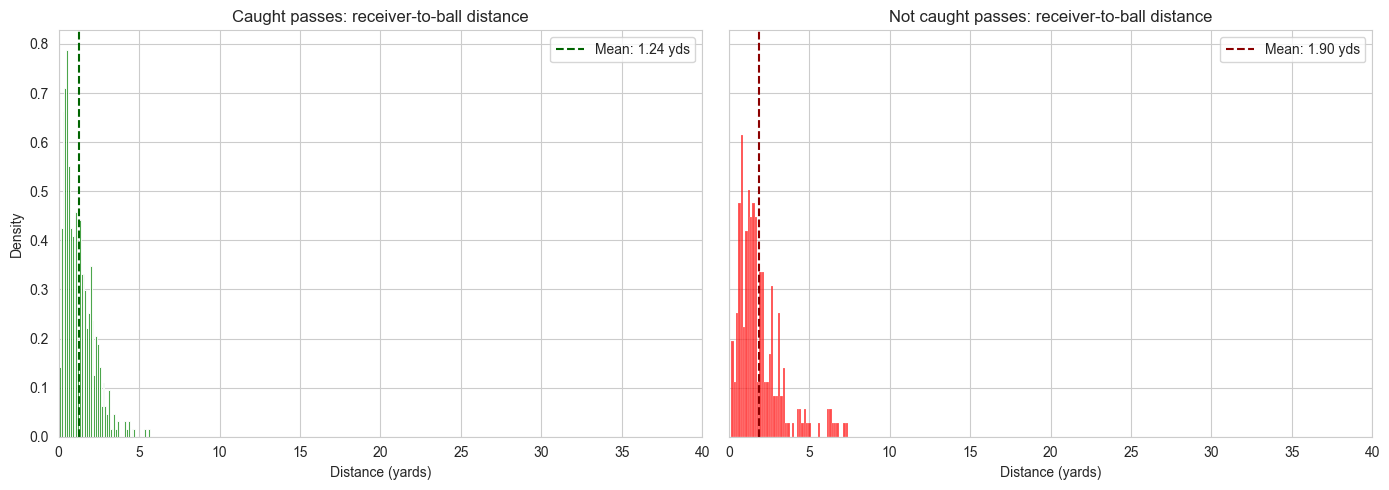

Mean distance (caught): 1.24 yards
Mean distance (not caught): 1.90 yards


In [ ]:
# Plot 1: Distance to ball distribution - caught vs not caught
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

caught_mask = route_level_df["is_complete"] == 1
not_caught_mask = route_level_df["is_complete"] == 0

sns.histplot(
    route_level_df.loc[caught_mask, "dist_to_ball"],
    bins=50,
    stat="density",
    ax=axes[0],
    color="green",
    alpha=0.7
)
axes[0].set_xlim(0, 40)
axes[0].set_title("Caught passes: receiver-to-ball distance")
axes[0].set_xlabel("Distance (yards)")
axes[0].axvline(route_level_df.loc[caught_mask, "dist_to_ball"].mean(), 
                color="darkgreen", linestyle="--", label=f"Mean: {route_level_df.loc[caught_mask, 'dist_to_ball'].mean():.2f} yds")
axes[0].legend()

sns.histplot(
    route_level_df.loc[not_caught_mask, "dist_to_ball"],
    bins=50,
    stat="density",
    ax=axes[1],
    color="red",
    alpha=0.7
)
axes[1].set_xlim(0, 40)
axes[1].set_title("Not caught passes: receiver-to-ball distance")
axes[1].set_xlabel("Distance (yards)")
axes[1].axvline(route_level_df.loc[not_caught_mask, "dist_to_ball"].mean(), 
                color="darkred", linestyle="--", label=f"Mean: {route_level_df.loc[not_caught_mask, 'dist_to_ball'].mean():.2f} yds")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Mean distance (caught): {route_level_df.loc[caught_mask, 'dist_to_ball'].mean():.2f} yards")
print(f"Mean distance (not caught): {route_level_df.loc[not_caught_mask, 'dist_to_ball'].mean():.2f} yards")


### Plot 2: Overall Distance to Ball Distribution

Distribution of receiver-to-ball distance for all passes.


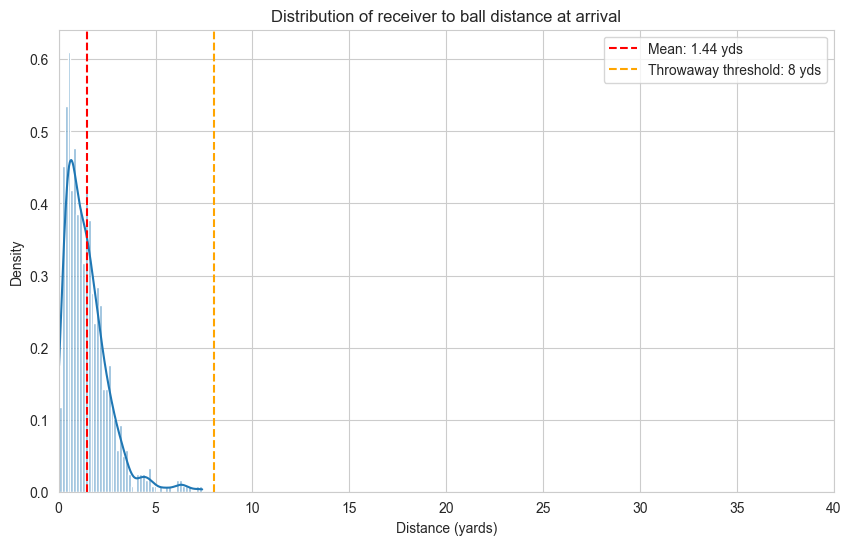

Statistics:
count    809.000000
mean       1.443601
std        1.118227
min        0.019998
25%        0.608277
50%        1.200043
75%        1.959312
max        7.408819
Name: dist_to_ball, dtype: float64


In [ ]:
# Plot 2: Overall distance to ball distribution
plt.figure(figsize=(10, 6))
sns.histplot(route_level_df["dist_to_ball"], bins=50, stat="density", kde=True)
plt.axvline(route_level_df["dist_to_ball"].mean(), color="red", linestyle="--", 
            label=f"Mean: {route_level_df['dist_to_ball'].mean():.2f} yds")
plt.axvline(THROWAWAY_DIST, color="orange", linestyle="--", 
            label=f"Throwaway threshold: {THROWAWAY_DIST} yds")
plt.xlim(0, 40)
plt.title("Distribution of receiver to ball distance at arrival")
plt.xlabel("Distance (yards)")
plt.ylabel("Density")
plt.legend()
plt.show()

print(f"Statistics:")
print(route_level_df["dist_to_ball"].describe())


### Plot 3: Separation by Catch Outcome

Compare nearest defender separation for completed vs incomplete passes.


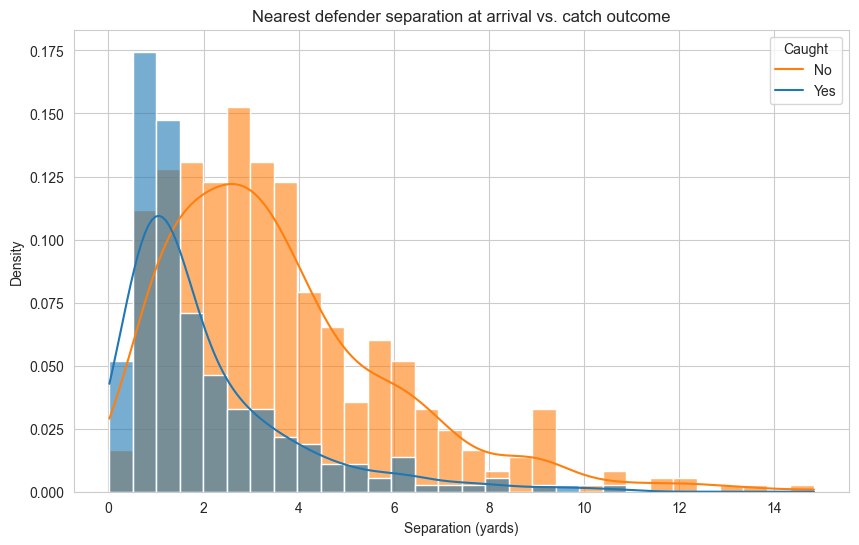

Mean separation (caught): inf yards
Mean separation (not caught): inf yards


In [ ]:
# Plot 3: Separation by catch outcome
plt.figure(figsize=(10, 6))
sns.histplot(
    data=route_level_df, 
    x="sep_nearest", 
    hue="is_complete", 
    bins=30, 
    stat="density", 
    kde=True,
    alpha=0.6
)
plt.title("Nearest defender separation at arrival vs. catch outcome")
plt.xlabel("Separation (yards)")
plt.ylabel("Density")
plt.legend(title="Caught", labels=["No", "Yes"])
plt.show()

print(f"Mean separation (caught): {route_level_df.loc[caught_mask, 'sep_nearest'].mean():.2f} yards")
print(f"Mean separation (not caught): {route_level_df.loc[not_caught_mask, 'sep_nearest'].mean():.2f} yards")


### Plot 4: Ball Distance vs Separation

Scatter plot showing the relationship between ball distance and defender separation.


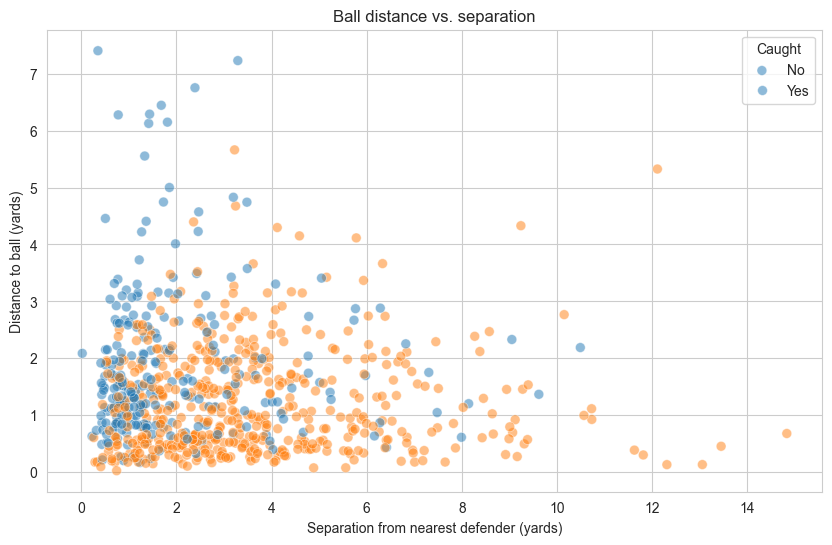

In [ ]:
# Plot 4: Ball distance vs separation
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=route_level_df, 
    x="sep_nearest", 
    y="dist_to_ball", 
    hue="is_complete", 
    alpha=0.5,
    s=50
)
plt.title("Ball distance vs. separation")
plt.xlabel("Separation from nearest defender (yards)")
plt.ylabel("Distance to ball (yards)")
plt.legend(title="Caught", labels=["No", "Yes"])
plt.show()


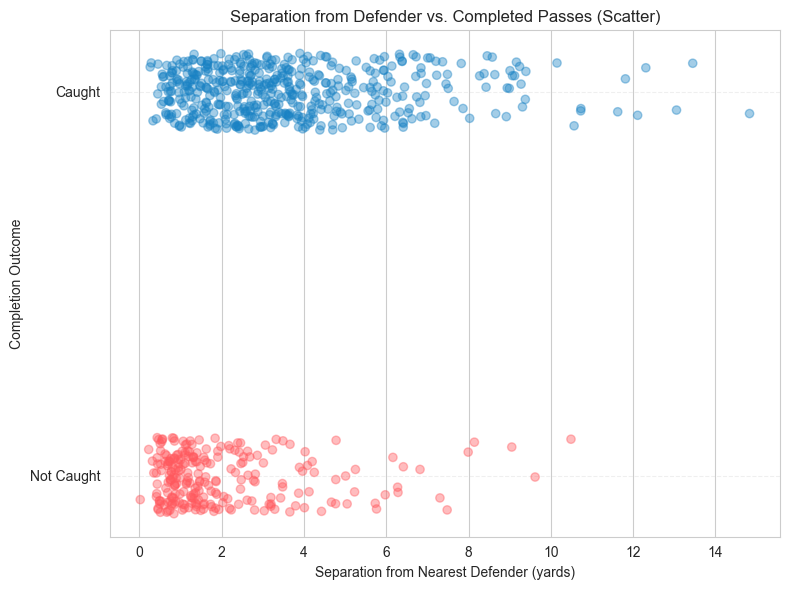

In [ ]:
# Scatter plot: Separation from defender vs. completed passes

plt.figure(figsize=(8, 6))
# For scatterplot, plot each route: x=separation, y=jittered (0: not caught, 1: caught)
# Add jitter for readability
import numpy as np
jitter = np.random.uniform(-0.1, 0.1, size=len(route_level_df))
plt.scatter(
    route_level_df["sep_nearest"], 
    route_level_df["is_complete"] + jitter,
    c=route_level_df["is_complete"].map({0: "#FF595E", 1: "#1982C4"}),
    alpha=0.4,
    label=None
)
plt.yticks([0, 1], ["Not Caught", "Caught"])
plt.xlabel("Separation from Nearest Defender (yards)")
plt.ylabel("Completion Outcome")
plt.title("Separation from Defender vs. Completed Passes (Scatter)")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



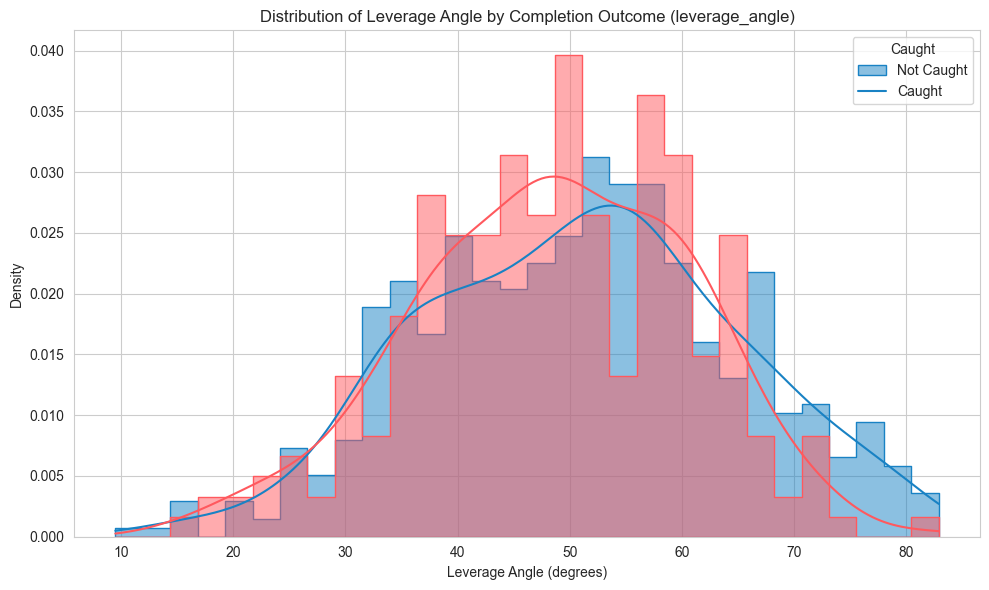

In [ ]:
# Plot: Leverage angle (or a similar angle metric) for caught vs not caught passes

plt.figure(figsize=(10, 6))

# Check for a column that matches "leverage_angle", "levegra_angle", "leverage" or similar
angle_col = None
for col in route_level_df.columns:
    if ("levegra_angle" in col.lower()
        or "leverage_angle" in col.lower()
        or ("leverage" in col.lower() and "angle" in col.lower())
        or (col.lower().startswith("angle") and "lev" in col.lower())):
        angle_col = col
        break

if angle_col is not None:
    sns.histplot(
        data=route_level_df,
        x=angle_col,
        hue="is_complete",
        bins=30,
        stat="density",
        element="step",
        common_norm=False,
        palette={0: "#FF595E", 1: "#1982C4"},
        kde=True,
        alpha=0.5
    )
    plt.title(f"Distribution of Leverage Angle by Completion Outcome ({angle_col})")
    plt.xlabel("Leverage Angle (degrees)")
    plt.ylabel("Density")
    plt.legend(title="Caught", labels=["Not Caught", "Caught"])
    plt.tight_layout()
    plt.show()
else:
    print("No leverage angle column found (like 'levegra_angle', 'leverage_angle') in route_level_df.")



### Plot 5: Catch Rate by Route Type

Bar plot showing catch rate for different route types (only routes with sufficient samples).


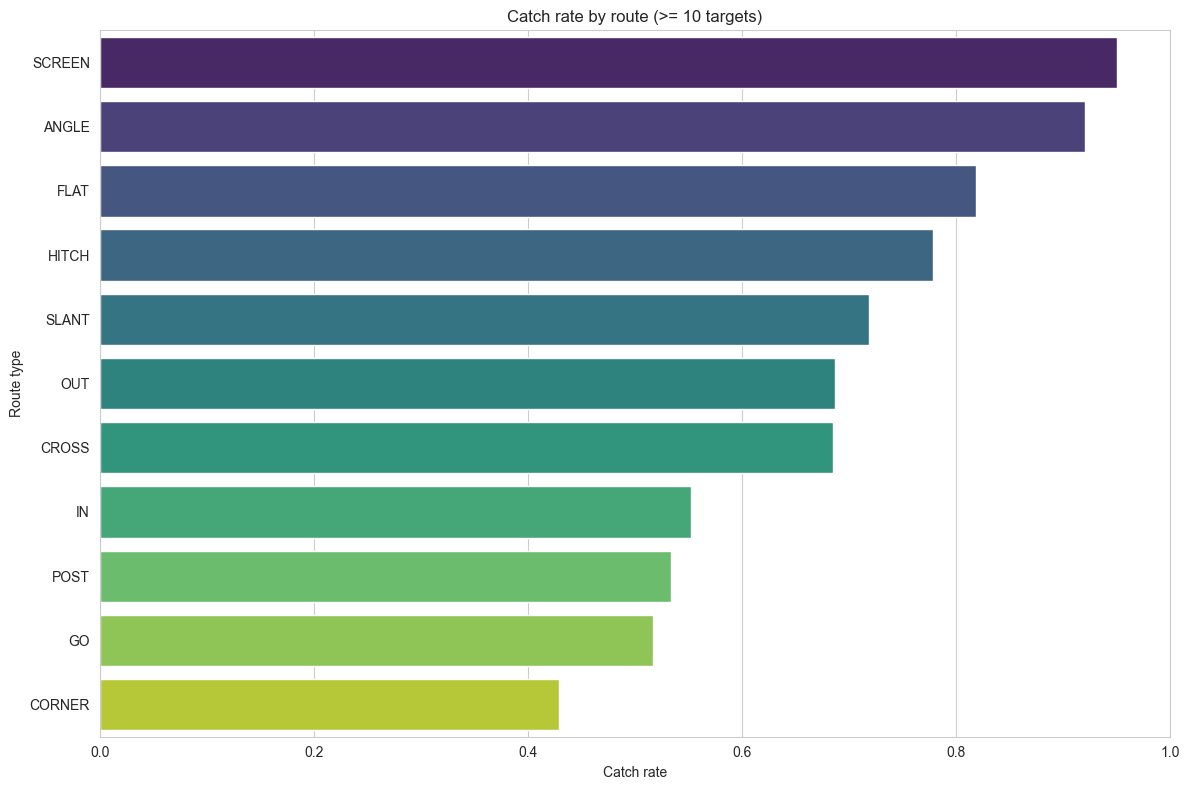


Top routes by catch rate:
     route      mean  count
9   SCREEN  0.950000     20
0    ANGLE  0.920000     25
3     FLAT  0.818182    121
5    HITCH  0.778571    140
10   SLANT  0.718310     71
7      OUT  0.687023    131
2    CROSS  0.685393     89
6       IN  0.552632     76
8     POST  0.533333     45
4       GO  0.516667     60


In [ ]:
# Plot 5: Catch rate by route type
min_samples = 10  # Minimum number of targets for a route to be included

route_stats = route_level_df.groupby("route").agg({
    "is_complete": ["mean", "count"]
}).reset_index()
route_stats.columns = ["route", "mean", "count"]
route_stats = route_stats[route_stats["count"] >= min_samples].sort_values("mean", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=route_stats.head(20), x="mean", y="route", palette="viridis")
plt.title(f"Catch rate by route (>= {min_samples} targets)")
plt.xlabel("Catch rate")
plt.ylabel("Route type")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

print(f"\nTop routes by catch rate:")
print(route_stats.head(10))


### Plot 6: Dominance Score Distribution

Compare dominance scores for completed vs incomplete passes.


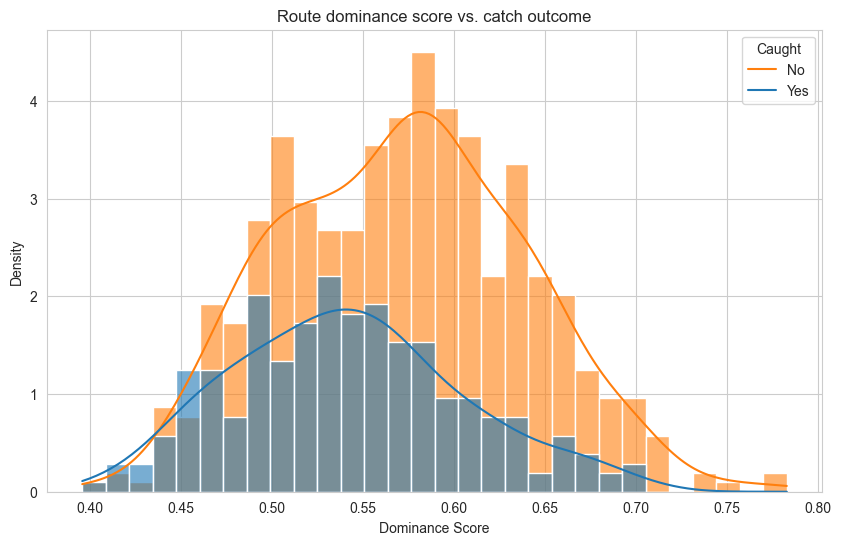

Mean dominance (caught): 0.572
Mean dominance (not caught): 0.541


In [ ]:
# Plot 6: Dominance score distribution
plt.figure(figsize=(10, 6))
sns.histplot(
    data=route_level_df, 
    x="dominance_score", 
    hue="is_complete", 
    bins=30, 
    stat="density", 
    kde=True,
    alpha=0.6
)
plt.title("Route dominance score vs. catch outcome")
plt.xlabel("Dominance Score")
plt.ylabel("Density")
plt.legend(title="Caught", labels=["No", "Yes"])
plt.show()

print(f"Mean dominance (caught): {route_level_df.loc[caught_mask, 'dominance_score'].mean():.3f}")
print(f"Mean dominance (not caught): {route_level_df.loc[not_caught_mask, 'dominance_score'].mean():.3f}")


## Step 8: Save Training DataFrame

Save the DataFrame to CSV for use in model training.


In [ ]:
# Save to CSV
output_file = "route_dominance_training_data.csv"
print(f"Saving training DataFrame to {output_file}...")
training_df.to_csv(output_file, index=False)
print(f"✓ Saved {len(training_df):,} rows to {output_file}")
print(f"  File size: {pd.io.common.file_size(output_file)}")


Saving training DataFrame to route_dominance_training_data.csv...
✓ Saved 31,766 rows to route_dominance_training_data.csv


AttributeError: module 'pandas.io.common' has no attribute 'file_size'

## Step 9: Interactive Visualization

Use the interactive visualizer to explore plays frame-by-frame. Navigate with arrow keys:
- **Left Arrow**: Previous frame
- **Right Arrow**: Next frame
- **Up Arrow**: Jump to first frame
- **Down Arrow**: Jump to last frame
- **'q' or Escape**: Quit


Creating interactive viewer for:
  Game ID: 2023090700
  Play ID: 101
  Targeted Receiver: Josh Reynolds (NFL ID: 44930)

Controls:
  Left Arrow  : Previous frame
  Right Arrow : Next frame
  Up Arrow    : Jump to first frame
  Down Arrow  : Jump to last frame
  'q' or Esc  : Quit

Click on the plot window and use arrow keys to navigate!
Calculating frame-by-frame dominance...

INTERACTIVE ROUTE DOMINANCE VIEWER
Controls:
  Left Arrow  : Previous frame
  Right Arrow : Next frame
  Up Arrow    : Jump to first frame
  Down Arrow  : Jump to last frame
  'q' or Esc  : Quit

Total frames: 47
Current frame: 1/47

Click on the plot window and use arrow keys to navigate!


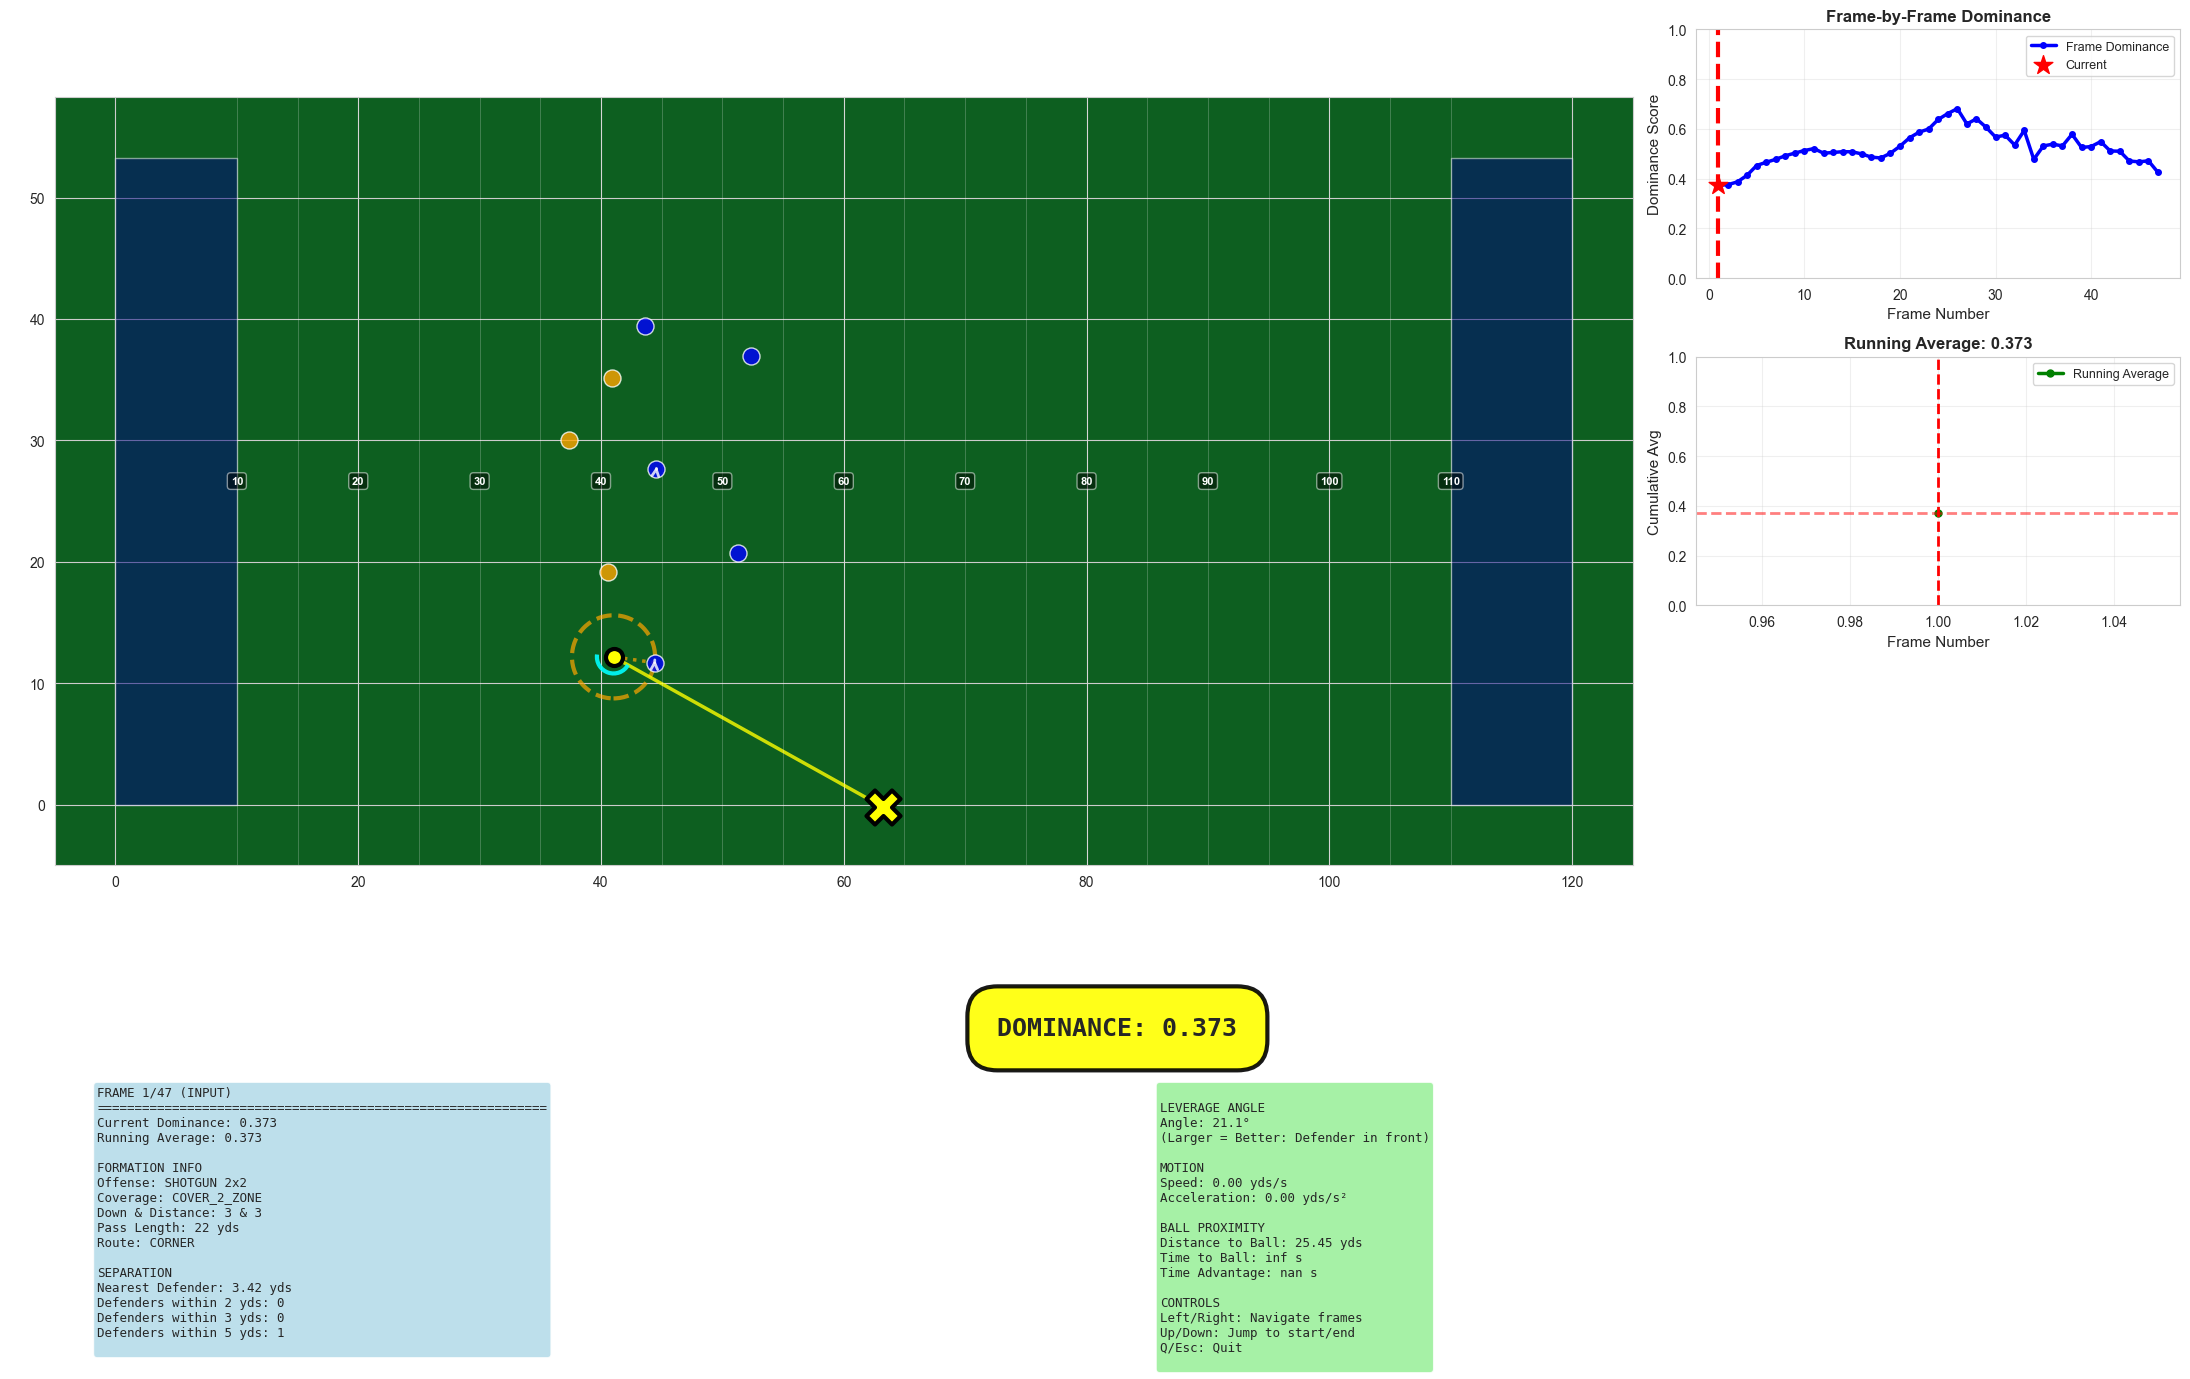

In [ ]:
# Select an example play to visualize
example_game_id = 2023090700
example_play_id = 101

# Get targeted receiver for this play
target_info = input_df[
    (input_df["game_id"] == example_game_id) &
    (input_df["play_id"] == example_play_id) &
    (input_df["player_role"] == "Targeted Receiver")
]

if not target_info.empty:
    target_nfl_id = target_info["nfl_id"].iloc[0]
    target_name = target_info["player_name"].iloc[0]
    
    print(f"Creating interactive viewer for:")
    print(f"  Game ID: {example_game_id}")
    print(f"  Play ID: {example_play_id}")
    print(f"  Targeted Receiver: {target_name} (NFL ID: {target_nfl_id})")
    print("\nControls:")
    print("  Left Arrow  : Previous frame")
    print("  Right Arrow : Next frame")
    print("  Up Arrow    : Jump to first frame")
    print("  Down Arrow  : Jump to last frame")
    print("  'q' or Esc  : Quit")
    print("\nClick on the plot window and use arrow keys to navigate!")
    
    # Create interactive viewer
    viewer = InteractiveRouteDominanceViewer(scorer, example_game_id, example_play_id, target_nfl_id)
else:
    print(f"Targeted receiver not found for play {example_game_id}-{example_play_id}")
    print("\nAvailable plays:")
    print(targeted_plays.head(10))


## Step 10: Compare Completed vs Incomplete Plays

Let's analyze differences between completed and incomplete passes.


In [ ]:
# Compare completed vs incomplete plays
print("="*80)
print("COMPLETED VS INCOMPLETE COMPARISON")
print("="*80)

# Define metrics to compare
metric_cols = [
    "dominance_score", "route_dominance_weighted", "sep_nearest",
    "receiver_speed", "leverage_angle", "time_advantage"
]

# Calculate route-level averages for each play
route_level = training_df.groupby(["game_id", "play_id", "is_complete"]).agg({
    "dominance_score": "mean",
    "route_dominance_weighted": "first",
    "sep_nearest": "mean",
    "receiver_speed": "mean",
    "leverage_angle": "mean",
    "time_advantage": "mean"
}).reset_index()

complete_stats = route_level[route_level["is_complete"] == 1][metric_cols].mean()
incomplete_stats = route_level[route_level["is_complete"] == 0][metric_cols].mean()

comparison = pd.DataFrame({
    "Completed": complete_stats,
    "Incomplete": incomplete_stats,
    "Difference": complete_stats - incomplete_stats
})

print(comparison)


COMPLETED VS INCOMPLETE COMPARISON
                          Completed  Incomplete  Difference
dominance_score            0.571742    0.541491    0.030250
route_dominance_weighted   0.570146    0.538512    0.031634
sep_nearest                     inf         inf         NaN
receiver_speed             4.154415    4.798799   -0.644384
leverage_angle            50.915874   48.541106    2.374768
time_advantage                  NaN         NaN         NaN


## Summary

You now have a comprehensive training DataFrame with:

✅ **Continuous frame numbering** - Each play has variable numbers of frames (pre-throw + post-throw), numbered sequentially starting from 1  
✅ **Throw status** column - Distinguishes pre-throw vs after-throw frames  
✅ **Nearest defender coordinates** - X, Y positions of closest defender at each frame  
✅ **Completion label** - Binary target variable (1 = Complete, 0 = Incomplete)  
✅ **All dominance metrics** - Separation, speed, acceleration, leverage angle, time advantage, etc.  
✅ **Route-level scores** - Aggregated scores (average, weighted, max, min) across all frames  
✅ **Play context** - Formation, coverage, down, distance, route type  
✅ **All weeks processed** - Data from weeks 1-18 included  

The DataFrame is saved as `route_dominance_training_data.csv` and ready for model training!

### Next Steps

1. **Feature Engineering**: Create additional features from existing metrics
2. **Model Training**: Train LSTM, Transformer, or other sequential models on the frame sequences
3. **Validation**: Split data and evaluate model performance
4. **Analysis**: Explore which metrics are most predictive of completion
